https://stackoverflow.com/questions/53838696/problems-regarding-pyomo-provided-math-functions

https://stackoverflow.com/questions/70048818/optimization-of-a-battery-storage-with-pyomo

https://gitlab.com/diw-evu/emobpy/emobpy/-/blob/master/emobpy/data/evspecs.json

https://github.com/L-Strobel/jointAnalysisCharging/tree/main/chargingmodel

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import math
import pyomo.environ as pyo 
import pyomo.opt as opt
from IPython.display import clear_output
from pyomo.opt import SolverFactory
import random
from pandas import Timestamp
import pickle
from varname import nameof
import matplotlib.dates as mdates


## Data input 

In [106]:
#emobpy import
processing_path = os.getcwd()
os.chdir("../emobpy")
data_path = os.getcwd()
os.chdir(processing_path)

consumption_ts = pd.read_pickle(os.path.join(data_path, "consumption"))
availability_ts = pd.read_pickle(os.path.join(data_path, "availability"))
car_properties_raw = pd.read_pickle(os.path.join(data_path, "properties")) 
soc_min = 0

profiles = len(availability_ts.columns[:-1])
time_steps = len(availability_ts.index)

In [107]:
#consumption = pd.DataFrame(data = np.array([[0, 0.5], [0, 0.5], [0.5, 0], [0.5, 0]]), columns = ["c_1[kW]", "c_2[kW]"])
consumption_raw = consumption_ts.iloc[:time_steps, :profiles] #kWh / 15 min timestep

#power = pd.DataFrame(pd.DataFrame(data = np.array([[1, 0], [1, 0], [0, 1], [0, 1]]), columns = ["p_1 [kW]", "p_2 [kW]"]))
power_raw = availability_ts.iloc[:time_steps, :profiles]

neg_power_magnitude_raw = power_raw

#set datetime indexes 
index = consumption_ts.index[:time_steps]
consumption_raw.index, power_raw.index, neg_power_magnitude_raw.index = index, index, index

In [108]:
step_duration = int(pd.infer_freq(index)[:-1]) / 60  #parts of an hour

soc_min = 0 #0%

## First intuition for data 

In [109]:
#average consuption of 200Wh per 100 km --> 
#median in Geramny is at about 11000 km per year
(consumption_raw*step_duration).sum().mean() / 0.2 

1906.9876183523336

In [110]:
#power ratings are mostly between 3 and 20 kW 
power_raw.mean(1).mean() 

9.542725931510962

In [7]:
def plot_step(df, consumption=True):
    df_ = df.copy()
    
    if type(df.index[0]) == int:
        df_.loc[df_.index[-1]+1,:] = df_.iloc[-1,:]
    else:
        df_.loc[str(pd.Timestamp(df_.index[-1] ) + 
                    pd.Timedelta(pd.infer_freq(index))),:
               ] = df_.iloc[-1,:]
        
    df_.index = pd.to_datetime(df_.index)
    
    fig, ax = plt.subplots(2)
    time_constrained=df_[df_.index.date <= df_.index[0].date()]
    x = time_constrained.index
    ax[0].step(x=x, y = time_constrained.iloc[:,2], where = "post")
    ax[1].step(x=x, y = time_constrained.sum(1).to_frame().rename(columns={0:"aggregated"}), where = "post")
    for i in [0,1]:
        ax[i].xaxis.set_major_locator(mdates.HourLocator())
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
        if consumption == True: ax[i].set_ylabel("kWh/15min")
        else: ax[i].set_ylabel("kW")
        if i == 0: ax[i].set_title("one single profile")
        else: ax[i].set_title("aggregated profile")
        ax[i].set_xlabel("hour of the day")
        
        ax[i].set_ylim(bottom=0)
        
    fig.tight_layout()
    plt.show()


Text(0, 0.5, 'consumption [kWh / 15min]')

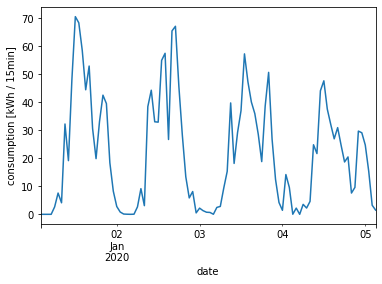

In [8]:
consumption_raw.iloc[10:400].sum(1).resample("1h").mean().plot()
plt.ylabel("consumption [kWh / 15min]")

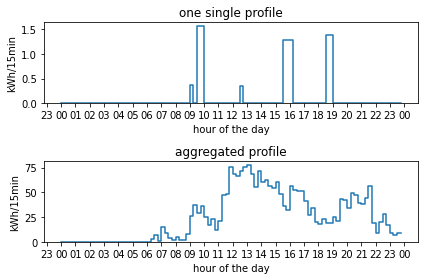

In [9]:
plot_step(consumption_raw)

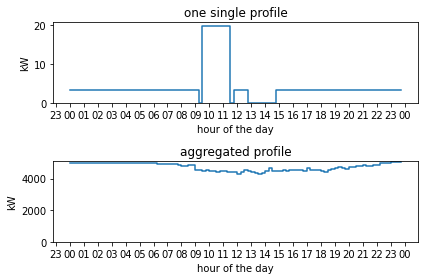

In [10]:
plot_step(power_raw, consumption = False)

In [11]:
#plausibility: Are power availability and battery size in reasonable 
#realtion to each other?
(consumption_raw*step_duration).sum(1).max() / car_properties_raw.iloc[2].sum()

0.0007002637506679387

# EES-transformation: Generating uncontrolled and latest charging ts

In [111]:
##level= [0, 2]
##level_ = [0, 1]

#set same names for columns
power_raw.columns = consumption_raw.columns
neg_power_magnitude_raw.columns = consumption_raw.columns
car_properties_raw.columns = consumption_raw.columns

In [13]:
solution_dict = {}
ees_constraints= pd.DataFrame()

for c in consumption_raw.columns.unique():
    
    for i, car in enumerate(consumption_raw[c].columns):
        consumption= consumption_raw[c].iloc[:,i]
        power= power_raw[c].iloc[:,i]
        neg_power_magnitude= neg_power_magnitude_raw[c].iloc[:,i]
        car_properties= car_properties_raw[c].iloc[:,i]
        
        solution_dict[car+str(i)] = {}
        level_0 = car_properties["soc_init"]
        level_T = car_properties.loc["soc_end"]
        battery_capacity = car_properties.loc["battery_capacity"]

        for model_type in ["m_late", "m_early"]:

            #Initialize model
            m = pyo.ConcreteModel()
            #initialize sets
            m.t = pyo.Set(initialize = index, ordered = True)

            #Initialize parameter
            m.consumption = pyo.Param(m.t, initialize=consumption.to_dict())
            m.power = pyo.Param(m.t, initialize=power.to_dict()) 
            m.neg_power = pyo.Param(m.t, initialize=neg_power_magnitude.to_dict()) 

            #Initialize variables
            m.CHARGE = pyo.Var(m.t, within = pyo.NonNegativeReals)
            m.DISCHARGE = pyo.Var(m.t, within = pyo.NonNegativeReals)
            m.LEVEL = pyo.Var(m.t, within = pyo.NonNegativeReals, 
                              bounds = (soc_min*battery_capacity,battery_capacity))

            #level constraints
            def recursive_level(m, t):
                if t == index[0]:
                    return m.LEVEL[t] == level_0 + (m.CHARGE[t] - m.DISCHARGE[t] - m.consumption[t] )*step_duration
                else:    
                    return m.LEVEL[t] == m.LEVEL[pd.Timestamp(t) - 
                                                     pd.Timedelta(pd.infer_freq(index))] + (
                        m.CHARGE[t] - m.DISCHARGE[t] - m.consumption[t] )*step_duration   
            m.Recursive_level = pyo.Constraint(m.t, rule = recursive_level)

            def final_level(m, t):
                if t == index[-1]:
                    return m.LEVEL[t] == level_T
                else: 
                    return pyo.Constraint.Skip
            m.Final_level = pyo.Constraint(m.t, rule=final_level)

            #bidirectional charging 
            def neg_power_min(m, t):
                return m.DISCHARGE[t] <= m.neg_power[t]
            m.Neg_power_min_restriction = pyo.Constraint(m.t, rule=neg_power_min)

            def power_max(m, t):
                return m.CHARGE[t] <= m.power[t]   
            m.Power_max_restriction = pyo.Constraint(m.t, rule=power_max)

            # objective function late
            def battery_level_sum(m, t): 
                return sum(m.LEVEL[t] for t in m.t) 

            if model_type == "m_late":
                sense = pyo.minimize
            elif model_type == "m_early":
                sense = pyo.maximize     
            m.Obj = pyo.Objective(rule=battery_level_sum, sense=sense)

            #find solver
            solvername='glpk'

            #prepare solver
            optimizer = opt.SolverFactory(solvername) 
            solved_model = optimizer.solve(m)        

            if pd.DataFrame.from_dict(m.LEVEL.extract_values(), orient='index')[0][-1]== None:
                level_series = pd.concat([
                    pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]),
                    pd.Series(level_0, index=index)
                ], axis=0)
                charge_df = pd.DataFrame(0, index=index, columns = [car])
                discharge_df = pd.DataFrame(0, index=index, columns = [car])
            else: 
                level_series = pd.concat([
                    pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]),
                    pd.DataFrame.from_dict(m.LEVEL.extract_values(), orient='index')[0]
                ], axis=0)
                charge_df = pd.DataFrame.from_dict(m.CHARGE.extract_values(), orient='index', columns = [car])
                discharge_df = pd.DataFrame.from_dict(m.DISCHARGE.extract_values(), orient='index', columns = [car])
            
            #store data in dictionary
            solution_dict[car+str(i)][model_type] = {}
            solution_dict[car+str(i)][model_type]["level"] = level_series
            solution_dict[car+str(i)][model_type]["charge"] = charge_df
            solution_dict[car+str(i)][model_type]["discharge"] = discharge_df
            level_index = solution_dict[car+str(i)][model_type]["level"].index
            if model_type == "m_early":
                solution_dict[car+str(i)]["level_differences"] = (solution_dict[car+str(i)]["m_late"]["level"] - 
                                                           solution_dict[car+str(i)]["m_early"]["level"]).to_frame().rename(columns={0:car})
                ees_constraints= pd.concat([ees_constraints, solution_dict[car+str(i)]["level_differences"]], axis = 1)

solution_dict = {}
ees_constraints= pd.DataFrame()
##zweite for schleife
for i, car in enumerate(consumption.columns): 
    car = i
    solution_dict[car] = {}
    level_0 = car_properties.loc["soc_init"][car] ##level[i]
    level_T = car_properties.loc["soc_end"][car] ##level_[i]
    battery_capacity = car_properties.loc["battery_capacity"][car] ##2
    
    for model_type in ["m_late", "m_early"]:
        
        #Initialize model
        m = pyo.ConcreteModel()
        #initialize sets
        m.t = pyo.Set(initialize = index, ordered = True)
        
        #Initialize parameter
        m.consumption = pyo.Param(m.t, initialize=consumption[car].to_dict())
        m.power = pyo.Param(m.t, initialize=power.loc[:,car].to_dict()) 
        m.neg_power = pyo.Param(m.t, initialize=neg_power_magnitude.loc[:,car].to_dict()) 

        #Initialize variables
        m.CHARGE = pyo.Var(m.t, within = pyo.NonNegativeReals)
        m.DISCHARGE = pyo.Var(m.t, within = pyo.NonNegativeReals)
        m.LEVEL = pyo.Var(m.t, within = pyo.NonNegativeReals, 
                          bounds = (soc_min*battery_capacity,battery_capacity))

        #level constraints
        def recursive_level(m, t):
            if t == index[0]:
                return m.LEVEL[t] == level_0 + (m.CHARGE[t] - m.DISCHARGE[t] - m.consumption[t] )#*step_duration
            else:    
                return m.LEVEL[t] == m.LEVEL[pd.Timestamp(t) - 
                                                 pd.Timedelta(pd.infer_freq(index))] + (
                    m.CHARGE[t] - m.DISCHARGE[t] - m.consumption[t] )#*step_duration   
        m.Recursive_level = pyo.Constraint(m.t, rule = recursive_level)

        def final_level(m, t):
            if t == index[-1]:
                return m.LEVEL[t] == level_T
            else: 
                return pyo.Constraint.Skip
        m.Final_level = pyo.Constraint(m.t, rule=final_level)

        #bidirectional charging 
        def neg_power_min(m, t):
            return m.DISCHARGE[t] <= m.neg_power[t]
        m.Neg_power_min_restriction = pyo.Constraint(m.t, rule=neg_power_min)
        
        def power_max(m, t):
            return m.CHARGE[t] <= m.power[t]   
        m.Power_max_restriction = pyo.Constraint(m.t, rule=power_max)
        
        # objective function late
        def battery_level_sum(m, t): 
            return sum(m.LEVEL[t] for t in m.t) 
        
        if model_type == "m_late":
            sense = pyo.minimize
        elif model_type == "m_early":
            sense = pyo.maximize     
        m.Obj = pyo.Objective(rule=battery_level_sum, sense=sense)
        
        #find solver
        solvername='glpk'
        
        #prepare solver
        optimizer = opt.SolverFactory(solvername) 
        solved_model = optimizer.solve(m)        
        
        if pd.DataFrame.from_dict(m.LEVEL.extract_values(), orient='index')[0][-1]== None:
            level_series = pd.concat([
                pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]),
                pd.Series(level_0, index=index)
            ], axis=0)
            charge_df = pd.DataFrame(0, index=index, columns = [car])
            discharge_df = pd.DataFrame(0, index=index, columns = [car])
        else: 
            level_series = pd.concat([
                pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]),
                pd.DataFrame.from_dict(m.LEVEL.extract_values(), orient='index')[0]
            ], axis=0)
            charge_df = pd.DataFrame.from_dict(m.CHARGE.extract_values(), orient='index', columns = [car])
            discharge_df = pd.DataFrame.from_dict(m.DISCHARGE.extract_values(), orient='index', columns = [car])
        #store data in dictionary
        solution_dict[car][model_type] = {}
        solution_dict[car][model_type]["level"] = level_series
        solution_dict[car][model_type]["charge"] = charge_df
        solution_dict[car][model_type]["discharge"] = discharge_df
        level_index = solution_dict[car][model_type]["level"].index
        if model_type == "m_early":
            solution_dict[car]["level_differences"] = (solution_dict[car]["m_late"]["level"] - 
                                                       solution_dict[car]["m_early"]["level"]).to_frame().rename(columns={0:car})
            ees_constraints= pd.concat([ees_constraints, solution_dict[car]["level_differences"]], axis = 1)

In [8]:
#with open('solution_dict.pickle', 'wb') as handle:
#    pickle.dump(solution_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('solution_dict.pickle', 'rb') as handle:
    solution_dict = pickle.load(handle)

In [15]:
#plausibility check: energy charged is the same for both scenarios (if battery capacity is exceeded)
solution_dict[car+str(i)]["m_early"]["charge"].sum() - solution_dict[car+str(i)]["m_early"]["discharge"].sum() - solution_dict[car+str(i)]["m_late"]["charge"].sum() + solution_dict[car+str(i)]["m_late"]["discharge"].sum()

KIA/e-Niro_64_kWh/2019   -5.684342e-14
dtype: float64

In [16]:
#prepare variables and functions for optimization 
def plot_results(variable, car):
    observations = 400
    if variable == "charge":
        x = index[:observations]
        fig, ax = plt.subplots(4)
        ax[0].step(x, solution_dict[car]["m_late"]["charge"][:observations],  where = "mid")
        ax[0].set_title("late_charging")
        
        ax[1].step(x, solution_dict[car]["m_early"]["charge"][:observations],  where = "mid")
        ax[1].set_title("uncontrolled_charging")
        
        ax[2].step(x, solution_dict[car]["m_late"]["discharge"][:observations],  where = "mid")
        ax[2].set_title("late_discharging")
        
        ax[3].step(x, solution_dict[car]["m_early"]["discharge"][:observations],  where = "mid")
        ax[3].set_title("uncontrolled_discharging")
        for i in range(0,4):
            ax[i].set_ylabel("kW")
            ax[i].xaxis.set_major_locator(mdates.HourLocator(interval = 6))
            ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
            ax[i].set_ylabel("kW")
    else: 
        observations = observations + 1
        x = level_index[:(observations)]
        fig, ax = plt.subplots(3)
        ax[0].plot(x, solution_dict[car]["m_late"]["level"][:observations])
        ax[0].set_ylim(0, solution_dict[car]["m_early"]["level"].max())
        ax[0].set_title("late_level")
        
        ax[1].plot(x, solution_dict[car]["m_early"]["level"][:observations])
        ax[1].set_ylim(0, solution_dict[car]["m_early"]["level"].max())
        ax[1].set_title("uncontrolled_level")
        
        ax[2].plot(x, solution_dict[car]["level_differences"][:observations])
        ax[2].set_title("level_solution differences")
        ax[2].set_ylim(-solution_dict[car]["m_early"]["level"].max(),)
        
        for i in range(0,3):
            ax[i].set_ylabel("kWh")
    
            
            ax[i].xaxis.set_major_locator(mdates.HourLocator(interval = 6))
            ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%H'))

    
    plt.tight_layout()
    plt.show()

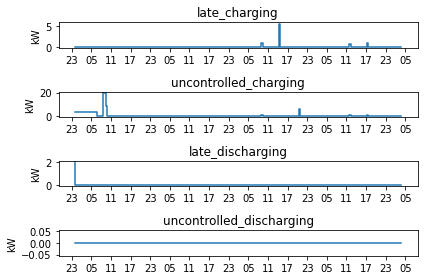

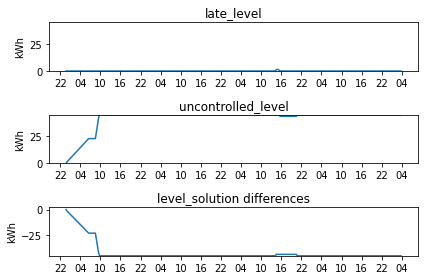

In [17]:
plot_results("charge", car+str(i)) 
plot_results("level", car+str(i))

## Processing EES-profiles: Aggregation

In [212]:
uncontrolled_level_accurate = pd.DataFrame()
uncontrolled_charge_accurate = pd.DataFrame()
early = pd.DataFrame()
late = pd.DataFrame()

for c in consumption_raw.columns.unique():
    for i, car in enumerate(consumption_raw[c].columns):
        #early = pd.concat([
        #    early, solution_dict[car+str(i)]["m_early"]["level"]
        #], axis=1).sum(1)
        #late = pd.concat([
        #   late, solution_dict[car+str(i)]["m_late"]["level"]
        #], axis=1).sum(1)
        uncontrolled_level_accurate = pd.concat([
            uncontrolled_level_accurate, solution_dict[car+str(i)]["m_early"]["level"]
        ], axis=1).sum(1)
        uncontrolled_charge_accurate = pd.concat([
            uncontrolled_charge_accurate, solution_dict[car+str(i)]["m_early"]["charge"]
        ], axis=1).sum(1)
        
uncontrolled_level_accurate.name = "uncontrolled_level"
uncontrolled_charge_accurate.name = "uncontrolled_charge"        
#ees_constraints_aggergated=late-early

In [95]:
ees_constraints_aggergated = ees_constraints.iloc[:time_steps+1, :profiles].sum(1)
level_index = ees_constraints_aggergated.index

In [96]:
#aggregation
naive_constraints_aggergated = pd.Series(data=sum(
    car_properties_raw.loc["battery_capacity"][ :profiles]), index=level_index) #all battery capicities
aggregated_max_battery = car_properties_raw.loc["battery_capacity"][ :profiles].sum()

<AxesSubplot:>

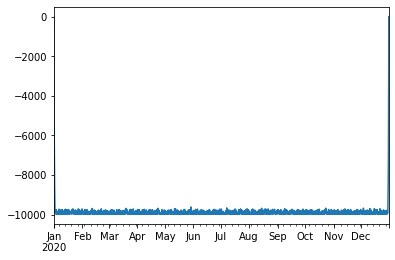

In [97]:
ees_constraints_aggergated.plot()

<AxesSubplot:>

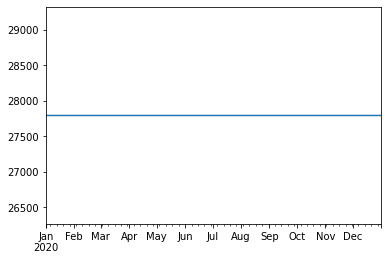

In [98]:
naive_constraints_aggergated.plot()

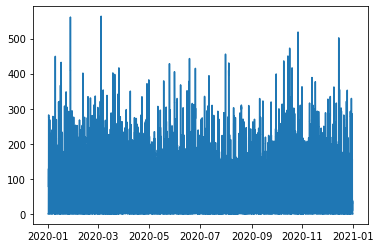

In [114]:
consumption_aggregated =  pd.concat([
    pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]), consumption_raw.loc[level_index[1:]].sum(1)
              ], axis = 0)
plt.step(consumption_aggregated.iloc[1:].resample("h").mean().index, consumption_aggregated.iloc[1:].resample("h").sum())

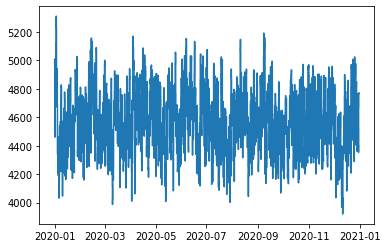

In [115]:
power_aggregated = pd.concat([
    pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]), power_raw.loc[level_index[1:]].sum(1)
              ], axis = 0)
plt.step(power_aggregated.iloc[1:].resample("4h").sum().index, power_aggregated.iloc[1:].resample("4h").mean())

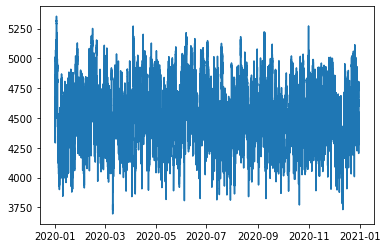

In [116]:
neg_power_aggregated = pd.concat([
    pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]), neg_power_magnitude_raw.loc[level_index[1:]].sum(1)
              ], axis = 0)
plt.step(neg_power_aggregated.iloc[1:].index, neg_power_aggregated.iloc[1:]) 

## Aggregated Optimization

In [18]:
#!pip install pickle5

In [19]:
import pickle5 as pickle

In [20]:
#create random prices [cent / kWh] 
#prices = pd.Series(data=[random.uniform(0.2, 0.5) for t in level_index], index=level_index)
#prices.resample("d").mean().plot()

with open("prices_2020", "rb") as fh:
    data = pickle.load(fh)

In [117]:
prices = data

prices = prices[prices.index >= "2019-12-31 22:45:00+01:00"]

prices.index =  prices.index.map(
    lambda x: pd.to_datetime(x.replace(tzinfo=None))
)
prices = prices[prices.index.drop_duplicates(keep=False)]
prices = prices.reindex(consumption_aggregated.index, method = "ffill") 
prices = prices / (10**3) # €/MWh --> €/kWh

<AxesSubplot:>

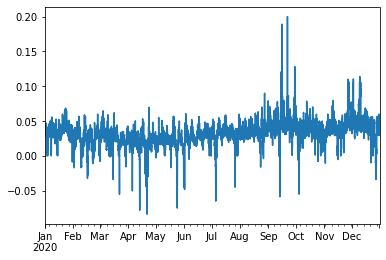

In [118]:
prices.plot()

Assumptions: 

- same price for (DIS)CHARGE
- 𝑓𝑙𝑒𝑥𝑖𝑏𝑖𝑙𝑖𝑡𝑦 𝑟𝑒𝑣𝑒𝑛𝑢𝑒𝑠 = sum(ees_charging_costs)
- controlled costs = uncontrolled_costs - 𝑙𝑒𝑥𝑖𝑏𝑖𝑙𝑖𝑡𝑦 𝑟𝑒𝑣𝑒𝑛𝑢𝑒𝑠 

In [119]:
aggregated_max_battery

27791.489999999998

In [120]:
agg_solutions = {}
level_0_agg = car_properties_raw.loc["soc_init"].sum() 
level_T_agg = car_properties_raw.loc["soc_end"].sum()

for model_type in ["ees", "naive"]:

    #Initialize model
    m_agg = pyo.ConcreteModel()

    #initialize sets
    m_agg.t = pyo.Set(initialize = ees_constraints_aggergated.index, ordered = True)

    m_agg.consumption_aggregated = pyo.Param(m_agg.t, initialize=consumption_aggregated.to_dict())
    m_agg.power = pyo.Param(m_agg.t, initialize=power_aggregated.to_dict()) 
    m_agg.neg_power = pyo.Param(m_agg.t, initialize=neg_power_aggregated.to_dict()) 

    m_agg.LEVEL = pyo.Var(m_agg.t, within = pyo.Reals)
    m_agg.CHARGE = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)
    m_agg.DISCHARGE_PHYS = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)
    m_agg.DISCHARGE_WAIT = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)

    if model_type == "ees":
        m_agg.ees_min = pyo.Param(m_agg.t, initialize=ees_constraints_aggergated.to_dict()) 
       

    #recursive level
        def recursive_level(m, t):
            if t == level_index[0]:
                return m_agg.LEVEL[t] == (m_agg.CHARGE[t] - m_agg.DISCHARGE_WAIT[t] - m_agg.DISCHARGE_PHYS[t])*step_duration   
            else:
                return m_agg.LEVEL[t] == m_agg.LEVEL[pd.Timestamp(t) - 
                                                 pd.Timedelta(pd.infer_freq(index))] + (
                    m_agg.CHARGE[t] - m_agg.DISCHARGE_WAIT[t] - m_agg.DISCHARGE_PHYS[t]) * step_duration   
    else:
        def recursive_level(m, t):
            if t == level_index[0]: 
                return m_agg.LEVEL[t] == level_0_agg + (m_agg.CHARGE[t]- m_agg.consumption_aggregated[t] - m_agg.DISCHARGE_PHYS[t] )*step_duration   
            else:
                return m_agg.LEVEL[t] == m_agg.LEVEL[pd.Timestamp(t) - 
                                                 pd.Timedelta(pd.infer_freq(index))] + (
                    m_agg.CHARGE[t] - m_agg.consumption_aggregated[t] - m_agg.DISCHARGE_PHYS[t]) * step_duration   
    m_agg.Recursive_level = pyo.Constraint(m_agg.t, rule = recursive_level)

    def level_constraint(m, t):
        if model_type=="ees":
            return m_agg.LEVEL[t] >= m_agg.ees_min[t] 
        else:
            return m_agg.LEVEL[t] <= aggregated_max_battery
    m_agg.Level_constraint = pyo.Constraint(m_agg.t, rule=level_constraint)
    
    def level_constraint_2(m, t):
        if model_type=="ees":
            return m_agg.LEVEL[t] <= 0
        else:
            return m_agg.LEVEL[t] >= soc_min*aggregated_max_battery
    m_agg.Level_constraint_2 = pyo.Constraint(m_agg.t, rule=level_constraint_2)
    
    def power_charge_max(m, t):
        return m_agg.CHARGE[t] <= m_agg.power[t]   
    m_agg.Power_charge_max = pyo.Constraint(m_agg.t, rule=power_charge_max)

    if model_type == "ees":
        def power_discharge_consumption_max(m, t):
            return m_agg.DISCHARGE_WAIT[t] <= m_agg.power[t]     
        m_agg.Power_discharge_consumption_max = pyo.Constraint(m_agg.t, rule=power_discharge_consumption_max)
    
    def power_discharge_phys_max(m, t):
        return m_agg.DISCHARGE_PHYS[t] <= m_agg.neg_power[t] 
    m_agg.Power_discharge_phys_max = pyo.Constraint(m_agg.t, rule=power_discharge_phys_max)

    # objective function
    if model_type == "ees":
        def min_ees_costs(m): 
            return sum(
                (m_agg.CHARGE[t]-m_agg.DISCHARGE_WAIT[t]-m_agg.DISCHARGE_PHYS[t]
                ) * prices[t] *step_duration 
                for t in m.t
            ) 
        m_agg.Obj_min_ees_costs = pyo.Objective(rule=min_ees_costs, sense=pyo.minimize)
    else:
        def min_naive_costs(m): 
            return sum(
                (m_agg.CHARGE[t]-m_agg.DISCHARGE_PHYS[t]) * prices[t] *step_duration 
                for t in m.t
            ) 
        m_agg.Obj_min_naive_costs = pyo.Objective(rule=min_naive_costs, sense=pyo.minimize)
        
    #find solver
    solvername='glpk'

    #prepare solver
    optimizer = opt.SolverFactory(solvername) 
    solved_model = optimizer.solve(m_agg, tee=True)        
    
    agg_solutions[model_type] = {}
    agg_solutions[model_type]["costs"] = solved_model['Problem']()['Lower bound']
    agg_solutions[model_type]["CHARGE"] = pd.DataFrame.from_dict(m_agg.CHARGE.extract_values(), orient='index', columns = [model_type])
    if model_type == "ees":
        agg_solutions[model_type]["DISCHARGE"] = pd.DataFrame.from_dict(m_agg.DISCHARGE_WAIT.extract_values(), orient='index', columns = [model_type]) + pd.DataFrame.from_dict(m_agg.DISCHARGE_PHYS.extract_values(), orient='index', columns = [model_type])
    else:
        agg_solutions[model_type]["DISCHARGE"] = pd.DataFrame.from_dict(m_agg.DISCHARGE_PHYS.extract_values(), orient='index', columns = [model_type])
    agg_solutions[model_type]["LEVEL"] = pd.DataFrame.from_dict(m_agg.LEVEL.extract_values(), orient='index', columns = [model_type])

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /var/folders/xb/lfd6_z7178g_6zv_ygw5vd4m0000gp/T/tmpjc6y_7l4.glpk.raw
 --wglp /var/folders/xb/lfd6_z7178g_6zv_ygw5vd4m0000gp/T/tmpyz4orufw.glpk.glp
 --cpxlp /var/folders/xb/lfd6_z7178g_6zv_ygw5vd4m0000gp/T/tmp3y7d_kje.pyomo.lp
Reading problem data from '/var/folders/xb/lfd6_z7178g_6zv_ygw5vd4m0000gp/T/tmp3y7d_kje.pyomo.lp'...
210391 rows, 140261 columns, 350650 non-zeros
1227238 lines were read
Writing problem data to '/var/folders/xb/lfd6_z7178g_6zv_ygw5vd4m0000gp/T/tmpyz4orufw.glpk.glp'...
1016843 lines were written
GLPK Simplex Optimizer 5.0
210391 rows, 140261 columns, 350650 non-zeros
Preprocessing...
35064 rows, 105191 columns, 140254 non-zeros
Scaling...
 A: min|aij| =  2.500e-01  max|aij| =  1.000e+00  ratio =  4.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 35064
      0: obj =   2.061155654e+01 inf =   8.237e+04 (15581)
   2940: obj =   2.

In [146]:
def plot_aggregated_results(model_type):
    obversvations = 200#len(ees_constraints_aggergated)
    x = level_index[:obversvations]
    fig, ax = plt.subplots(3)
    ax[0].step(x, 
               pyo.value(agg_solutions[model_type]["CHARGE"].values[:obversvations]), where="pre")
    ax[0].set_title("{}_charging".format(model_type))
    
    
    ax[1].step(x, 
               pyo.value(agg_solutions[model_type]["DISCHARGE"].values[:obversvations]), where="pre")
    ax[1].set_title("{}_discharging".format(model_type))
    
    
    ax[2].plot(x, 
               pyo.value(agg_solutions[model_type]["LEVEL"].values[:obversvations]))
    ax[2].set_title("{}_level".format(model_type))
    ax[2].set_ylabel("kWh")
    
    
    for i in range(0,2):
        ax[i].set_ylabel("kWh/15min")
        ax[i].set_xticks(pd.date_range(x[0], x[-1], freq="D"))
        #plt.set_xticklabels(rotation= 45)
        plt.xticks(rotation= 45)
    fig.autofmt_xdate(rotation=45)


    plt.tight_layout()
    plt.show()

# Analysis

In [137]:
agg_overest_solutions = {}

for model_type in ["m_early_agg", "m_late_agg"]:
    #Initialize model
    m_agg = pyo.ConcreteModel()

    #initialize sets
    m_agg.t = pyo.Set(initialize = ees_constraints_aggergated.index, ordered = True)

    m_agg.consumption_aggregated = pyo.Param(m_agg.t, initialize=consumption_aggregated.to_dict())
    m_agg.power = pyo.Param(m_agg.t, initialize=power_aggregated.to_dict()) 
    m_agg.neg_power = pyo.Param(m_agg.t, initialize=neg_power_aggregated.to_dict()) 

    m_agg.LEVEL = pyo.Var(m_agg.t, within = pyo.NonNegativeReals, bounds=(
        soc_min*aggregated_max_battery, aggregated_max_battery))
    m_agg.CHARGE = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)
    m_agg.DISCHARGE = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)

    #level constraints
    def recursive_level(m_agg, t):
        if t == level_index[0]:
            return m_agg.LEVEL[t] == level_0_agg + m_agg.CHARGE[t] - m_agg.consumption_aggregated[t]
        else:    
            return m_agg.LEVEL[t] == m_agg.LEVEL[pd.Timestamp(t) - 
                                             pd.Timedelta(pd.infer_freq(level_index))] + (
                m_agg.CHARGE[t] - m_agg.consumption_aggregated[t] - m_agg.DISCHARGE[t] )
    m_agg.Recursive_level = pyo.Constraint(m_agg.t, rule = recursive_level)

    #bidirectional charging 
    def neg_power_min(m, t):
        return m.DISCHARGE[t] <= m.neg_power[t]
    m_agg.Neg_power_min_restriction = pyo.Constraint(m_agg.t, rule=neg_power_min)

    def power_max(m, t):
        return m.CHARGE[t] <= m.power[t]   
    m_agg.Power_max_restriction = pyo.Constraint(m_agg.t, rule=power_max)
    
    def final_level(m_agg, t):
        if t == index[-1]:
            return m_agg.LEVEL[t] == level_T_agg
        else: 
            return pyo.Constraint.Skip
    m_agg.Final_level = pyo.Constraint(m_agg.t, rule=final_level)

    # objective function late
    def battery_level_sum(m_agg, t): 
        return sum(m_agg.LEVEL[t] for t in m_agg.t) 
    if model_type == "m_late_agg":
        sense = pyo.minimize
    elif model_type == "m_early_agg":
        sense = pyo.maximize     
    m_agg.Obj = pyo.Objective(rule=battery_level_sum, sense=sense)

    #find solver
    solvername='glpk'

    #prepare solver
    optimizer = opt.SolverFactory(solvername) 
    solved_model = optimizer.solve(m_agg)        

    #store data in dictionary
    agg_overest_solutions[model_type] = pd.DataFrame.from_dict(
        m_agg.LEVEL.extract_values(), orient='index')[0]

In [237]:
#overestimation in kWh how much could be shifted from uncontrolled charging?
overestimation_dict = {}

overestimation = 1 + (
    (agg_overest_solutions["m_late_agg"] - agg_overest_solutions["m_early_agg"]).sum()
    - ees_constraints_aggergated.sum()
) / ees_constraints_aggergated.sum()

print(
    "potential overestimation factor: " + str(
        overestimation) + " : " + str((
    (agg_overest_solutions["m_late_agg"] - agg_overest_solutions["m_early_agg"]).sum()
    - ees_constraints_aggergated.sum()
) / ees_constraints_aggergated.sum()*100) + " %"
)
                                                  
overestimation_dict[f'profiles: {profiles}, steps: {time_steps}'] =  overestimation 

potential overestimation factor: 2.8118903785419582 : 181.18903785419582 %


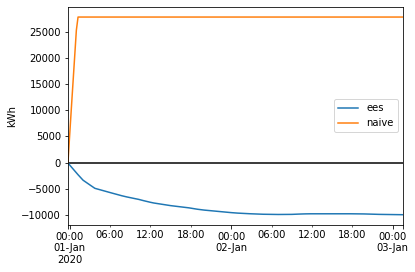

In [255]:
pd.concat([
    ees_constraints_aggergated, (agg_overest_solutions["m_early_agg"] - agg_overest_solutions["m_late_agg"])
], keys = ["ees", "naive"],axis=1).iloc[:200].plot(ylabel="kWh")

plt.hlines(0, level_index[0], level_index[-1], "black")

Text(0, 0.5, 'kWh')

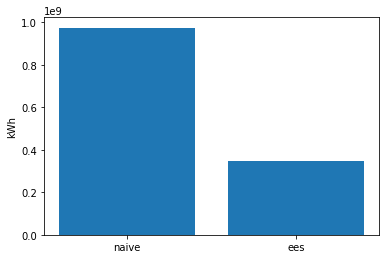

In [263]:
plt.bar(["naive", "ees"], [
    (agg_overest_solutions["m_early_agg"] - agg_overest_solutions["m_late_agg"]).sum(),
    -ees_constraints_aggergated.sum()
])
plt.ylabel("kWh")

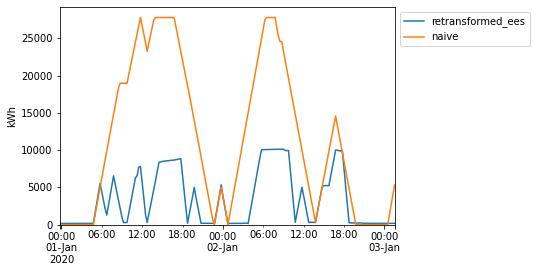

In [148]:
#controlled charging (physical) = uncontrolled charging - ees_dis + ee_scharging
retransformed_ees_level = pd.concat([
    uncontrolled_level_accurate, agg_solutions["ees"]["LEVEL"]
], axis=1).sum(1)
retransformed_ees_level.name = "retransformed_ees"

pd.concat([
    retransformed_ees_level, agg_solutions["naive"]["LEVEL"]
], axis=1).iloc[:200].plot(ylabel="kWh", ylim=0)


plt.legend(bbox_to_anchor=(1.0, 1.0))

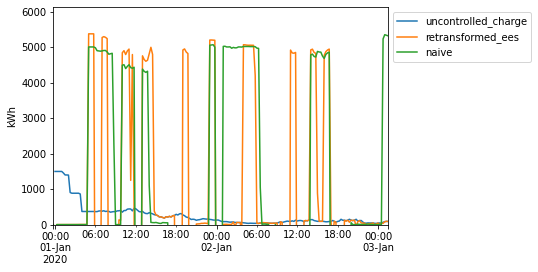

In [213]:
#controlled charging (physical) = uncontrolled charging - ees_dis + ee_scharging
retransformed_ees_charge = pd.concat([
    uncontrolled_charge_accurate.loc[level_index[1:]], agg_solutions["ees"]["CHARGE"], - agg_solutions["ees"]["DISCHARGE"]
], axis=1).sum(1)

naive_dis_charge = pd.concat([
    agg_solutions["naive"]["CHARGE"], - agg_solutions["naive"]["DISCHARGE"]
], axis=1).sum(1)

retransformed_ees_charge.name, naive_dis_charge.name = "retransformed_ees", "naive"

pd.concat([
    uncontrolled_charge_accurate, retransformed_ees_charge, naive_dis_charge
], axis=1).iloc[:200].plot(ylabel="kWh", ylim=0)
plt.legend(bbox_to_anchor=(1.0, 1.0))

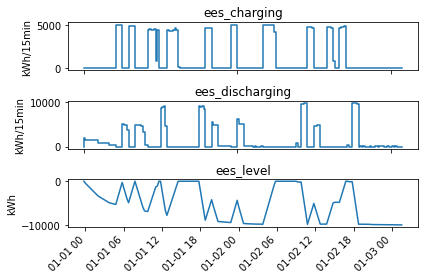

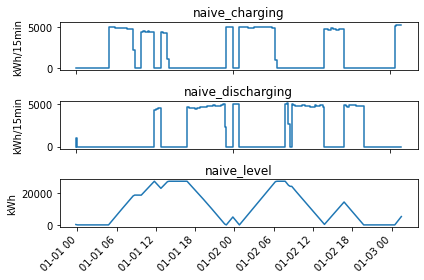

In [216]:
plot_aggregated_results("ees")
plot_aggregated_results("naive")

## Cost

In [217]:
uncontrolled_costs = sum([
    uncontrolled_charge_accurate[i] * prices[i] for i in index
])
controlled_costs_ees = sum([
    retransformed_ees_charge[i] * prices[i] for i in index
])
controlled_costs_naive = sum([
    naive_dis_charge[i] * prices[i] for i in index
])

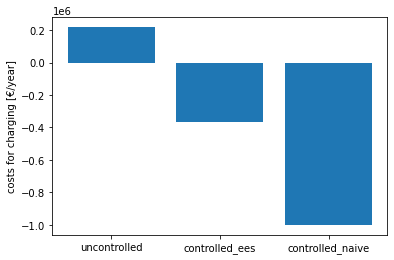

In [221]:
#costs
plt.bar(x = ["uncontrolled", "controlled_ees", "controlled_naive"],  height=[
    uncontrolled_costs, controlled_costs_ees, controlled_costs_naive
])
plt.ylabel("costs for charging [€/year]")
plt.show()

In [222]:
#overestimation in % €
(controlled_costs_ees + controlled_costs_naive) / (-controlled_costs_naive)

-1.3658236932288144